In [1]:
import os

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers, models
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
import numpy as np
import cv2
import time

2024-01-23 20:37:15.772009: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 20:37:16.010227: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 20:37:16.010253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 20:37:16.011440: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 20:37:16.117817: I tensorflow/core/platform/cpu_feature_g

In [2]:
WORKING_DIR = "/mnt/c/Users/2002j/Desktop/pliki/Uni/sem5/CV/project3/data"

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-23 20:37:19.112802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 20:37:19.133485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 20:37:19.133525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
images = os.listdir(WORKING_DIR)
train_images = images[-750:]

In [5]:
image_size = (256, 256)
sample_img = tf.io.read_file(f"{WORKING_DIR}/{train_images[0]}")
sample_img = tf.io.decode_png(sample_img)
print(sample_img.shape)

2024-01-23 20:37:19.240006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 20:37:19.240045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 20:37:19.240053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 20:37:19.440718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 20:37:19.440751: I tensorflow/compile

(500, 500, 3)


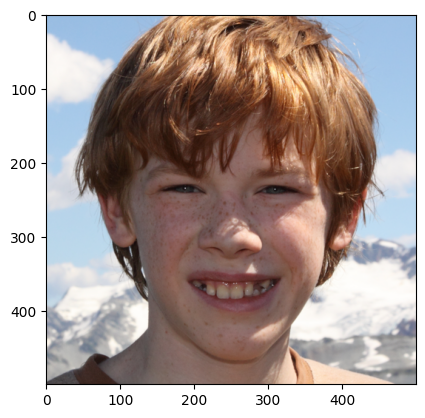

In [6]:
plt.figure()
plt.imshow(sample_img)

In [7]:
images = []

for file in train_images:
    img = cv2.imread(f"{WORKING_DIR}/{file}")
    img = cv2.resize(img, image_size)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

X = np.array(images) / 255.0
del images

In [8]:
def destory_patches(image):
    augmented_img = image.copy()
    for _ in range(np.random.randint(10, 20)):
        patch_size_x = np.random.randint(20, 30)
        patch_size_y = np.random.randint(20, 30)
        x = np.random.randint(1, image.shape[1] - patch_size_x)
        y = np.random.randint(1, image.shape[0] - patch_size_y)
        augmented_img[y:y + patch_size_y, x:x+patch_size_x, :] = 0.0

    return augmented_img

In [9]:
destoryed_images = []

for img in X:
    destoryed_images.append(destory_patches(img))

X_destoryed = np.array(destoryed_images)
del destoryed_images

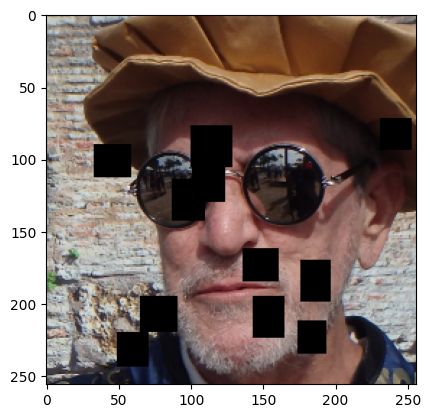

In [10]:
plt.figure()
plt.imshow(X_destoryed[196])

In [11]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.3))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
autoencoder = Generator()

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.compile(optimizer='adam', loss=[SSIMLoss], metrics=['mse', 'mae', SSIMLoss])

In [13]:
early = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
reduce = ReduceLROnPlateau(monitor='val_loss', patience=8),

autoencoder.fit(X_destoryed, X,
epochs=150,
batch_size=16,
validation_split=0.3,
shuffle=True, 
callbacks=[early, reduce])

Epoch 1/150


2024-01-23 20:37:35.299621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-23 20:37:35.614914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-23 20:37:37.242117: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-01-23 20:37:38.636200: I tensorflow/compiler/xla/service/servic

33/33 [==============================] - 17s 274ms/step - loss: 0.5181 - mse: 0.0502 - mae: 0.1867 - SSIMLoss: 0.5173 - val_loss: 0.6770 - val_mse: 0.3486 - val_mae: 0.5285 - val_SSIMLoss: 0.6757 - lr: 0.0010
Epoch 2/150
33/33 [==============================] - 3s 90ms/step - loss: 0.3129 - mse: 0.0243 - mae: 0.1045 - SSIMLoss: 0.3128 - val_loss: 0.4658 - val_mse: 0.0403 - val_mae: 0.1683 - val_SSIMLoss: 0.4656 - lr: 0.0010
Epoch 3/150
33/33 [==============================] - 3s 88ms/step - loss: 0.2551 - mse: 0.0147 - mae: 0.0766 - SSIMLoss: 0.2552 - val_loss: 0.4668 - val_mse: 0.0466 - val_mae: 0.1813 - val_SSIMLoss: 0.4675 - lr: 0.0010
Epoch 4/150
33/33 [==============================] - 3s 87ms/step - loss: 0.2145 - mse: 0.0084 - mae: 0.0614 - SSIMLoss: 0.2144 - val_loss: 0.4903 - val_mse: 0.0515 - val_mae: 0.1911 - val_SSIMLoss: 0.4915 - lr: 0.0010
Epoch 5/150
33/33 [==============================] - 3s 95ms/step - loss: 0.1836 - mse: 0.0058 - mae: 0.0515 - SSIMLoss: 0.1835 - val_

In [14]:
# save_path_json = "model.json"
# save_path_hdf5 = "model.hdf5"

# if os.path.isfile(save_path_json):
#         os.remove(save_path_json)
    
# if os.path.isfile(save_path_hdf5):
#     os.remove(save_path_hdf5)

# with open(save_path_json, "w") as model_file:
#     model_file.write(autoencoder.to_json())

# keras.saving.save_model(
#     autoencoder,
#     save_path_hdf5,
#     save_format="h5"
# )

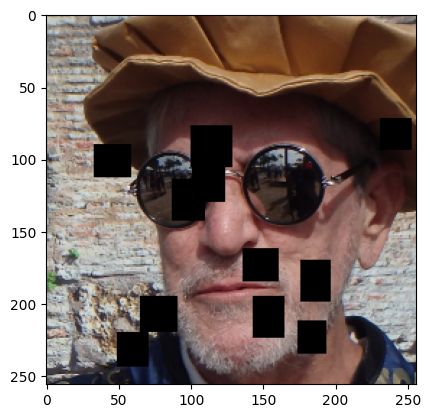

In [15]:
plt.figure()
plt.imshow(X_destoryed[196])

In [16]:
X_regenerated = autoencoder.predict(X_destoryed)

: 

: 

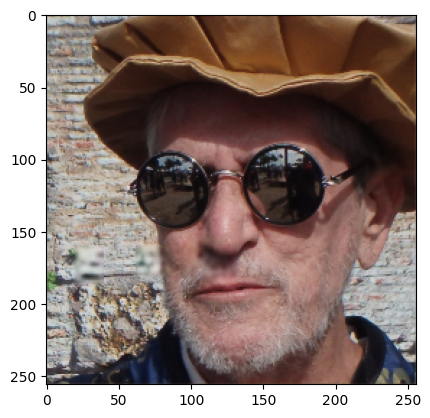

In [ ]:
plt.figure()
plt.imshow(X_regenerated[196])

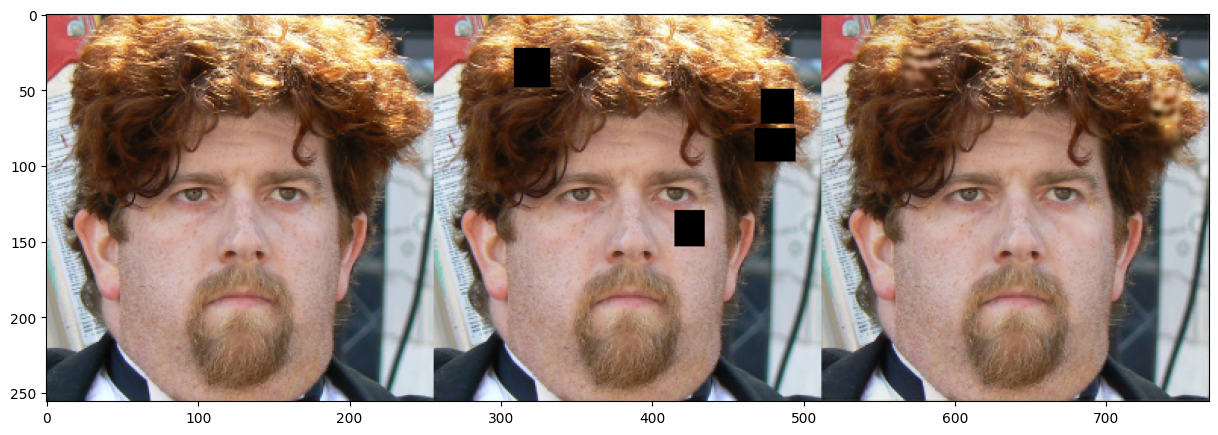

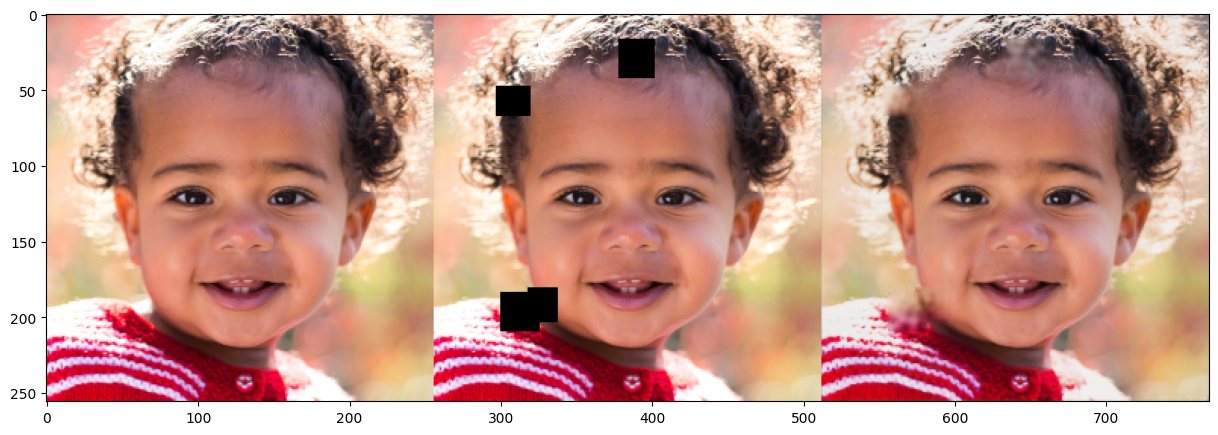

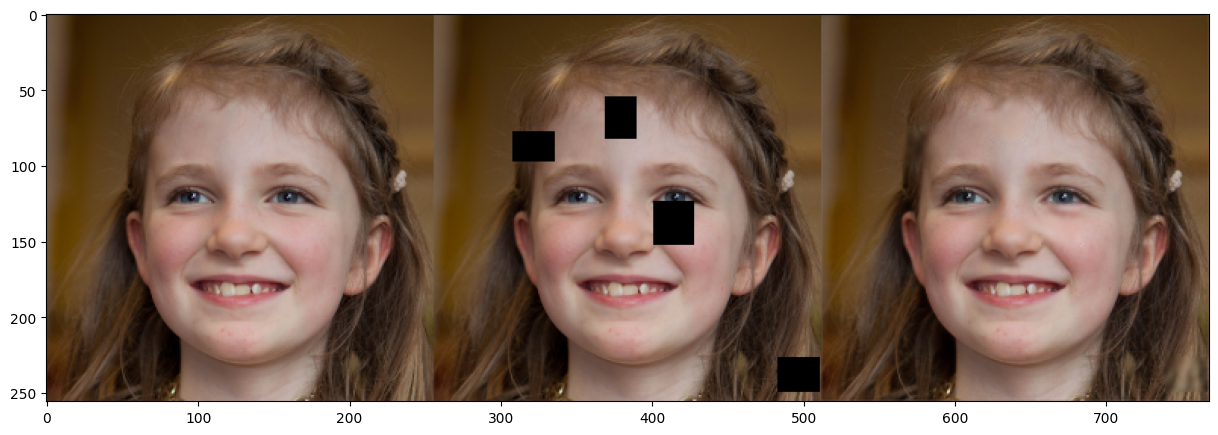

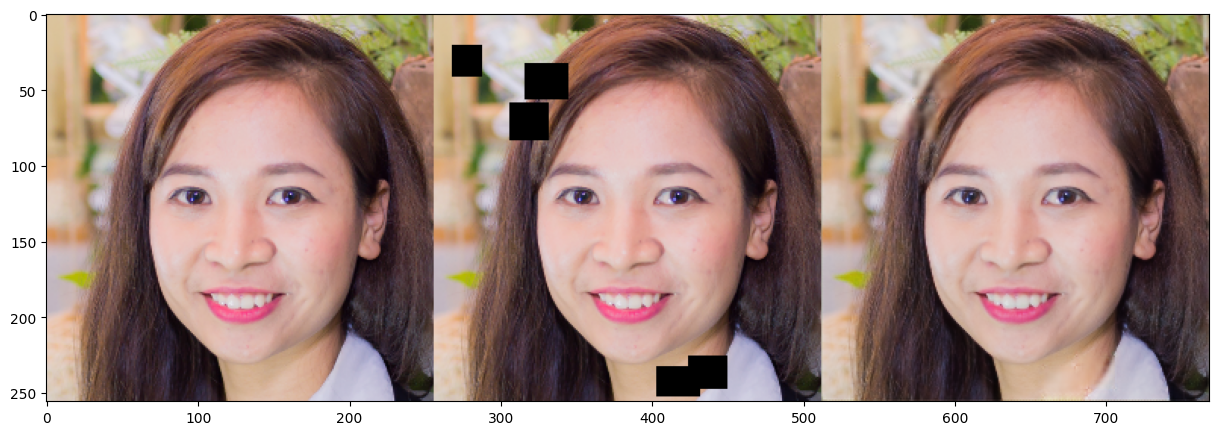

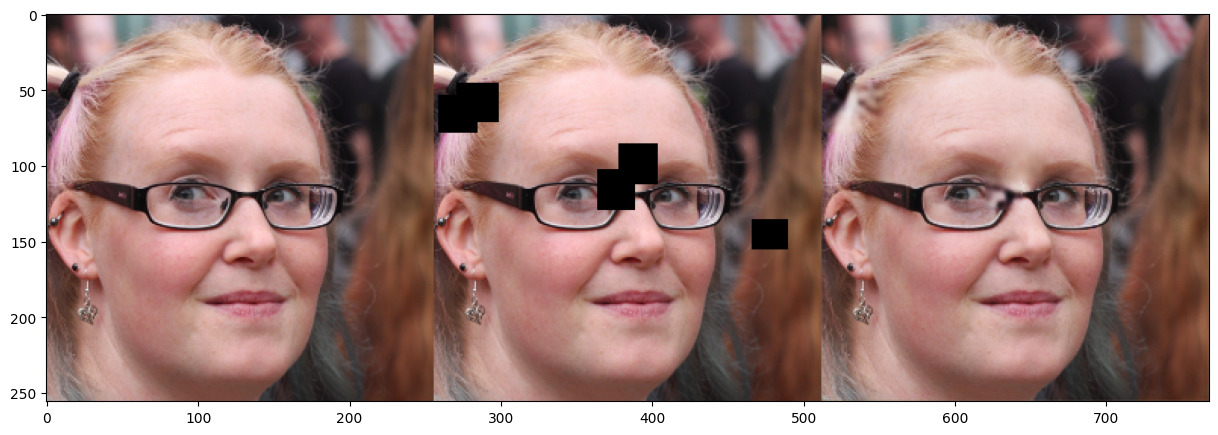

In [ ]:
for i in np.random.choice(len(X_regenerated), size=5, replace=False):
    plt.figure(figsize=(15, 50))
    plt.imshow(np.concatenate([X[i], X_destoryed[i], X_regenerated[i]], axis=1))